In [1]:
import pandas as pd

## Data Loading and Exploratory Data Analysis

I sourced the data from the [US Cities Database](https://simplemaps.com/data/us-cities), which draws primarily from the US Census Bureau.  From here, we have a nicely-organized CSV we can import using pandas.  I'll flag my intial dataframe as `_raw` to indicate that no data cleaning or transformation has yet occurred.

In [2]:
# Load CSV into a dataframe
cities_raw = pd.read_csv("D:/Directory/what_makes_a_hotspot/data/uscitiesv1.4.csv")

Performing an initial round of EDA is incredibly important.  Accurate results can only be achieved if you start with a good understanding of the structure, format, and eccentricities of the data you are using.  I typically start with an `.info()` call to get an idea of the shape and structure.

In [3]:
cities_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36651 entries, 0 to 36650
Data columns (total 16 columns):
city                 36651 non-null object
city_ascii           36651 non-null object
state_id             36651 non-null object
state_name           36651 non-null object
county_fips          36651 non-null int64
county_name          36651 non-null object
lat                  36651 non-null float64
lng                  36651 non-null float64
population           19361 non-null float64
population_proper    19361 non-null float64
density              36651 non-null float64
source               36651 non-null object
incorporated         36651 non-null bool
timezone             36650 non-null object
zips                 36650 non-null object
id                   36651 non-null int64
dtypes: bool(1), float64(5), int64(2), object(8)
memory usage: 4.2+ MB


Our dataframe is 36,651 rows x 16 columns.  We can see the columns we expect to be floats or ints (lat, lng, population, etc) were processed appropriately, which means we likely don't have any nonsense values sneaking into these fields.  

However, we can see there are only 19,361 entries for the population data out of our expected 36,651.  Given that population is what we are primarily after with this data set, we'll need to do some investigation here to at least ensure our top entries are accurately populated.

Let's take a look at the first few entries.

In [4]:
cities_raw.head()

,city,city_ascii,state_id,state_name,county_fips,county_name,lat,lng,population,population_proper,density,source,incorporated,timezone,zips,id
0,Prairie Ridge,Prairie Ridge,WA,Washington,53053,Pierce,47.1443,-122.1408,NaN,NaN,1349.8,polygon,False,America/Los_Angeles,98360 98391,1840037882
1,Edison,Edison,WA,Washington,53057,Skagit,48.5602,-122.4311,NaN,NaN,127.4,polygon,False,America/Los_Angeles,98232,1840017314
2,Packwood,Packwood,WA,Washington,53041,Lewis,46.6085,-121.6702,NaN,NaN,213.9,polygon,False,America/Los_Angeles,98361,1840025265
3,Wautauga Beach,Wautauga Beach,WA,Washington,53035,Kitsap,47.5862,-122.5482,NaN,NaN,261.7,point,False,America/Los_Angeles,98366,1840037725
4,Harper,Harper,WA,Washington,53035,Kitsap,47.5207,-122.5196,NaN,NaN,342.1,point,False,America/Los_Angeles,98366,1840037659


We have a list of cities with supporting location and population information.  Immediately, we can see the issue with missing population data.  None of the first five entries show valid numbers.  However, none of the entries here appear to be candidates for our "Top 100 Cities".  If we think about this, we're really only interested in about 0.2% of the entries in this data.  Let's focus in on this group and ensure what we need is present.

In [5]:
cities_raw[['city', 'population', 'population_proper']].sort_values(by='population', ascending=False).head(15)

,city,population,population_proper
12359,New York,19164071.0,8537673.0
16410,Los Angeles,12740381.0,3976322.0
20044,Chicago,8639278.0,2704958.0
3640,Miami,6247425.0,453579.0
7504,Dallas,5634307.0,1317929.0
13625,Philadelphia,5591554.0,1567872.0
8142,Houston,5424720.0,2303482.0
1684,Washington,5191844.0,681170.0
21452,Atlanta,5080712.0,472522.0
27010,Boston,4556916.0,673184.0


When you're not sure about the validity of a public data set, it's a good idea to compare it to a second source.  If we take a look at the Census Bureau's [American Fact Finder](https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?src=bkmk), our `population_proper` column matches pretty closely for each city's 2017 estimate.  I'm feeling better about this!

This begs the question, though, should our analysis center around this `population_proper` column or the wider area `population`?  We can see some stark differences between the two fields.  Atlanta, for instance, has a population proper of 472,552 but a wider population of 5,080,712 - almost 11x times larger!  If we sample a few of the top cities' Wikipedia pages ([Los Angeles](https://en.wikipedia.org/wiki/Los_Angeles), [Chicago](https://en.wikipedia.org/wiki/Chicago), [Atlanta](https://en.wikipedia.org/wiki/Atlanta)), the population field seems reasonably close to their urban area boundaries.  If the purpose is to find the best restaurants in America's population centers, using this approximate urban area population seems the better choice.

Let's get rid of our null population entries take a deeper look at the distribution of population in the overall data set.

In [6]:
# Isolate only cities with population data
cities = cities_raw[cities_raw.population.notnull()]

# Ensure the results match our expectations
cities.shape

(19361, 16)

Our shape matches the output of our `.info()` call on the raw data set! We should be dealing only with complete data now.  

### Plotting Distribution
With the nulls taken care of, we can dig a little deeper into our EDA.  Let's plot our population distribution.

In [7]:
# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

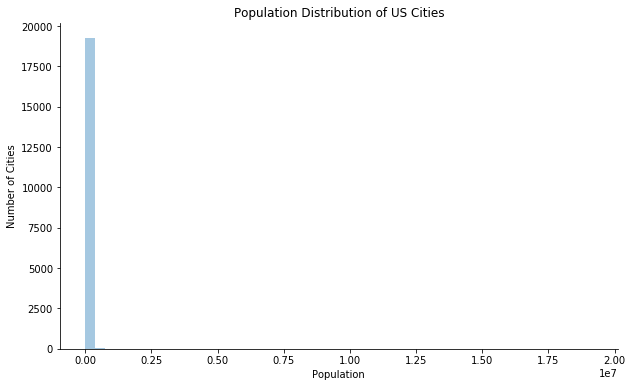

In [8]:
# Create plot
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.distplot(cities.population, norm_hist=False, kde=False)

# Format chart
plt.title("Population Distribution of US Cities")
ax.set_xlabel("Population")
ax.set_ylabel("Number of Cities")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

Well, perhaps that was to be expected.  The vast majority of US cities fall somewhere in a range under 100,000 while a few metropolises completely skew our distribution.  Let's once again trim down to our desired set of cities and to get a better idea of how things look.

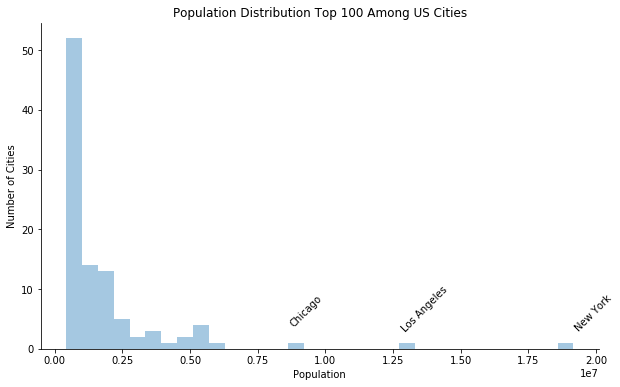

In [16]:
# Isolate our top 100
cities_100 = cities.sort_values(by='population', ascending=False).head(100)

# Create plot
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.distplot(cities_100.population, norm_hist=False, kde=False)

# Format chart
plt.title("Population Distribution Top 100 Among US Cities")
ax.set_xlabel("Population")
ax.set_ylabel("Number of Cities")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Highlight our outliers
ax.annotate(cities_100.iloc[0].city, xy=(cities_100.iloc[0].population, 8), rotation=45, horizontalalignment='left')
ax.annotate(cities_100.iloc[1].city, xy=(cities_100.iloc[1].population, 9.5), rotation=45)
ax.annotate(cities_100.iloc[2].city, xy=(cities_100.iloc[2].population, 8), rotation=45)

plt.show()

Things are looking more interpretable now, but the distribution continues to have quite the long tail.  Over 50 of our cities here still fall under around 500,000 residents.  Computer - enhance!

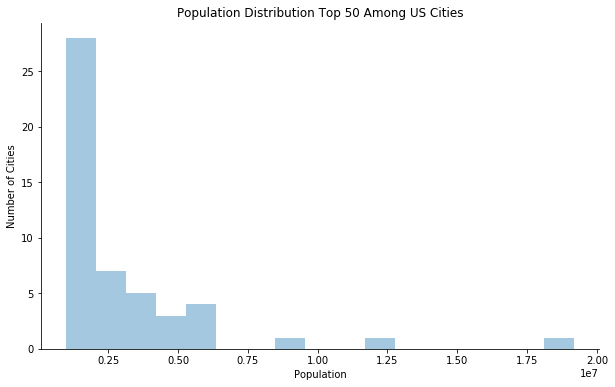

In [17]:
# Isolate our top 100
cities_50 = cities.sort_values(by='population', ascending=False).head(50)

# Create plot
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.distplot(cities_50.population, norm_hist=False, kde=False)

# Format chart
plt.title("Population Distribution Top 50 Among US Cities")
ax.set_xlabel("Population")
ax.set_ylabel("Number of Cities")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

In [18]:
cities_50

,city,city_ascii,state_id,state_name,county_fips,county_name,lat,lng,population,population_proper,density,source,incorporated,timezone,zips,id
12359,New York,New York,NY,New York,36061,New York,40.6943,-73.9249,19164071.0,8537673.0,10934.0,polygon,True,America/New_York,11229 11226 11225 11224 11222 11221 11220 1138...,1840034016
16410,Los Angeles,Los Angeles,CA,California,6037,Los Angeles,34.1140,-118.4068,12740381.0,3976322.0,3275.0,polygon,True,America/Los_Angeles,90291 90293 90292 90029 91316 91311 90035 9000...,1840020491
20044,Chicago,Chicago,IL,Illinois,17031,Cook,41.8373,-87.6861,8639278.0,2704958.0,4585.0,polygon,True,America/Chicago,60018 60649 60641 60640 60643 60642 60645 6064...,1840000494
3640,Miami,Miami,FL,Florida,12086,Miami-Dade,25.7840,-80.2102,6247425.0,453579.0,4866.0,polygon,True,America/New_York,33129 33125 33126 33127 33128 33149 33144 3314...,1840015149
7504,Dallas,Dallas,TX,Texas,48113,Dallas,32.7938,-96.7659,5634307.0,1317929.0,1490.0,polygon,True,America/Chicago,75287 75098 75233 75231 75234 75254 75251 7525...,1840019440
13625,Philadelphia,Philadelphia,PA,Pennsylvania,42101,Philadelphia,40.0076,-75.1340,5591554.0,1567872.0,4511.0,polygon,True,America/New_York,19154 19151 19150 19153 19152 19102 19103 1910...,1840000673
8142,Houston,Houston,TX,Texas,48201,Harris,29.7871,-95.3936,5424720.0,2303482.0,1412.0,polygon,True,America/Chicago,77069 77068 77061 77060 77063 77062 77065 7706...,1840020925
1684,Washington,Washington,DC,District of Columbia,11001,District of Columbia,38.9047,-77.0163,5191844.0,681170.0,4301.0,polygon,True,America/New_York,20010 20011 20012 20015 20228 20520 20307 2041...,1840006060
21452,Atlanta,Atlanta,GA,Georgia,13121,Fulton,33.7627,-84.4231,5080712.0,472522.0,1370.0,polygon,True,America/New_York,30334 30331 30332 30309 30308 30307 30303 3035...,1840013660
27010,Boston,Boston,MA,Massachusetts,25025,Suffolk,42.3189,-71.0838,4556916.0,673184.0,5373.0,polygon,True,America/New_York,02120 02121 02122 02124 02125 02126 02127 0212...,1840000455
